# Math PhD EDA

Scott Atkinson

## [0. Contents](#0._Contents) <a id='0._Contents'></a>
## [1. Import libraries and data](#1._Import_libraries_and_data)
## [2. Create advisor table](#2._Create_advisor_table)
* We filter the dataframe obtained in the datawrangling step to only admit entries with at least one student and with publication, year, and student data.

## [3. Career lengths](#3._Career_lengths)
* We create a career length column to allow us to compute rough averages of various features.
* We also create columns for the number of students acquired in 5, 10, 15, 20, 25, 30, 35, and 40 years.

## [4. Boxplots for number of students over various time intervals](#4._Boxplots_for_number_of_students_over_various_time_intervals)
* We create boxplots for each of `num_students` columns created in the previous step.

## [5. Histograms for number of students over various time intervals](#5._Histograms_for_number_of_students_over_various_time_intervals)
* We examine the histograms for each of the `num_students` columns.

## [6. Histograms for number of students acquired over various 5-year intervals](#6._Histograms_for_number_of_students_acquired_over_various_5-year_intervals)
* We create columns giving the increment of students acquired over 5-year intervals and examine their histograms.

## [7. Boxplots for number of students acquired over various 5-year intervals](#7._Boxplots_for_number_of_students_acquired_over_various_5-year_intervals)
* We look at the boxplots for the columns created in the previous step.

## [8. CDFs and PDFs for number of students over various time intervals](#8._CDFs_and_PDFs_for_number_of_students_over_various_time_intervals)
* We take a closer look at the distributions of the `num_students` columns by plotting their CDFs and PDFs.  Apparently the CDFs indicate that their is a close fit with exponential distributions.

## [9. Obtaining more features](#9._Obtaining_more_features)
* We obtain the following features:
    * `Advisor_students`: The number of students the candidate's advisor produced.
    * `School_producers`: This is the ratio of PhDs produced by a school who went on to advise PhD students of their own to the total number of PhDs produced by a school.
    * `pubs_per_year`: Publications per year according to the candidate's career length.
    * `citations_per_year`: Citations per year according to the candidate's career length.

## [10. Obtaining dataframe for advisors with career length at least 20 years](#10._Obtaining_dataframe_for_advisors_with_career_length_at_least_20_years)


## [11. Visualizations of correlations](#11._Visualizations_of_correlations)
* ### [11.1 Heatmap](#11.1_Heatmap)
* ### [11.2 Pairplot](#11.2_Pairplot)
* ### [11.3 Scatter plots with 4 regression curves](#11.3_Scatter_plots_with_4_regression_curves)
* ### [11.4 Aside](#11.4_Aside)






## 1. Import libraries and data<a id='1._Import_libraries_and_data'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# import scipy.stats as stats
# from sklearn.linear_model import PoissonRegressor, LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score
# from sklearn.neural_network import MLPClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


import time
import datetime

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = 13, 13
sns.set()

Applying the operations below is computationally intensive, so we can load the dataframes obtained in this notebook using by running the following cell

In [2]:
ad = pd.read_excel('advisor_table.xlsx')
ad20 = pd.read_excel('advisor20_table.xlsx')

In [ ]:
df = pd.read_excel('../DataWrangling/MGP_MScN.xlsx')

In [ ]:
df.set_index('MGP_ID', inplace = True, drop = False)
df

## 2. Create advisor table (records with at least one student and with publication, year, student data)<a id='2._Create_advisor_table'></a>

In [ ]:
def students(rec):
    stset = []
    for j in range(1,7):
        for stu in df[df['Advisor_%s_MGP_ID'%(j)] == rec].index:
            stset.append(stu)
    return set(stset)

In [ ]:
ad = df[(df['num_students']>0) & (df['Total_Pubs']!= -1) & (df['Year']>0) & (df['Earliest_Pub'] > -1) & (df['num_students'] == df['MGP_ID'].apply(students).apply(len))]
ad.shape

## 3. Career lengths and number of students per year<a id='3._Career_lengths'></a>

The function for career length is given as follows: $$f(x) = \left\{ \begin{array}{lcr} 2020 - x & \text{if} & x \geq 1980\\ \max(L - x) & \text{if} & x < 1980\end{array}\right. $$ where $x$ is the degree year, and $L$ is the degree year of the latest student.

In [ ]:
def career_length(rec):
    x = df.loc[rec,'Year']
    if x == 0:
        x = df.loc[rec,'Earliest_Pub']
        if x == -1:
            return 40
    if x >= 1980:
        return 2020 - x
    elif students(rec) != set():
        stu_years = []
        for stu in students(rec):
            stu_years.append(df.loc[stu, 'Year'])
        L = max(stu_years)
        if L != 0:
            c = max([L-x,40])
            if c < 100:
                return c
            else:
                return 40
        else:
            return 40
    else:
        return 40

In [ ]:
ad['career_length'] = ad['MGP_ID'].apply(career_length)
ad

Now going to look at how many students an advisor produces in 5 year increments.  For now we will ignore students with unknown degree years.  

In [ ]:
def cum_students(rec):
    """ gives number of students after i*5 years"""
    ls = []
    rec_year = df.loc[rec,'Year']
    stu_set = students(rec)
    stu_year_dict = {student: df.loc[student, 'Year'] for student in stu_set}
    for i in range(8):
        t=[]
        for student in stu_set:
            year = stu_year_dict[student]
            if year > 0 and year <= rec_year + ((i+1)*5):
                t.append(student)
        ls.append(t)
    return [len(j) for j in ls]

In [ ]:
for i in range(8):
    ad['num_students_in_%s_years'%((i+1)*5)] = 0

In [ ]:
cols = ['num_students_in_%s_years'%((i+1)*5) for i in range(8)]
for id in ad.index:
    ad.loc[id, cols] = cum_students(id)

## 4. Boxplots for number of students over various time intervals<a id='4._Boxplots_for_number_of_students_over_various_time_intervals'></a>

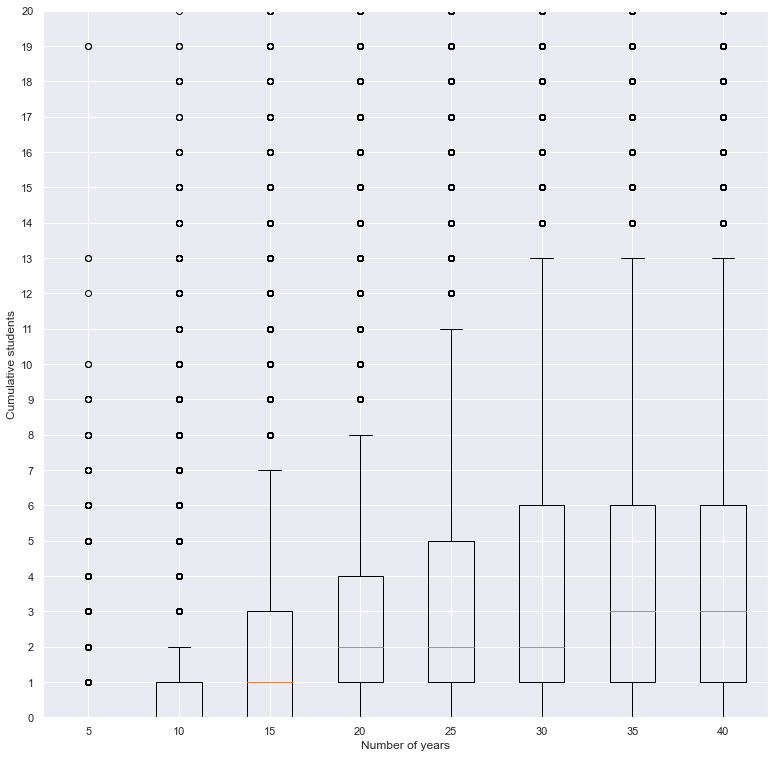

In [3]:
plt.boxplot([ad['num_students_in_%s_years'%(i)] for i in [(j+1)*5 for j in range(0,8)]])
plt.xlabel('Number of years')
plt.ylabel('Cumulative students')
plt.xticks([1,2,3,4,5,6,7,8], [5,10,15,20,25,30,35,40])
plt.yticks([i for i in range(21)])
plt.ylim(0,20)
plt.show()

## 5. Histograms for number of students over various time intervals<a id='5._Histograms_for_number_of_students_over_various_time_intervals'></a>

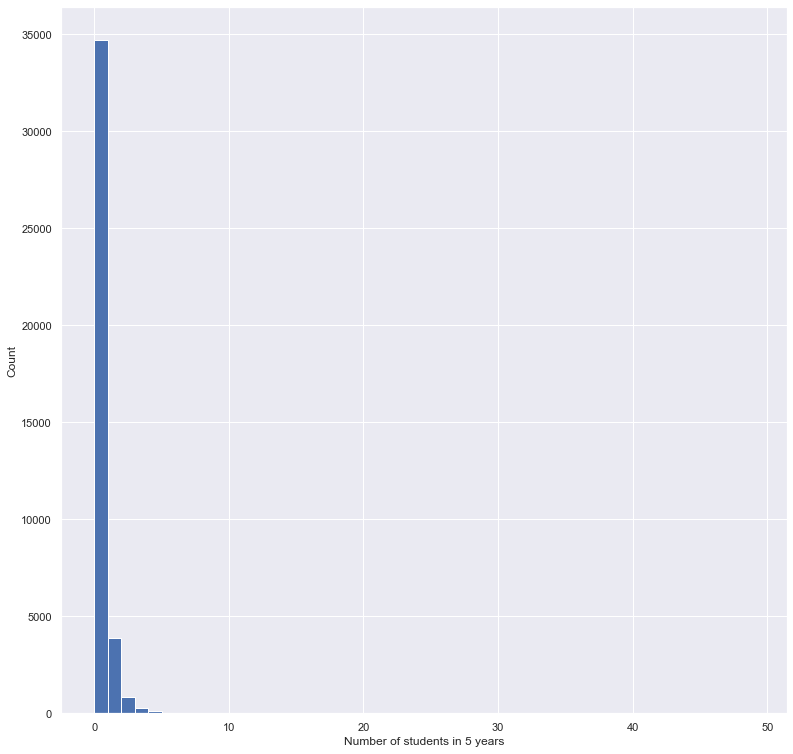

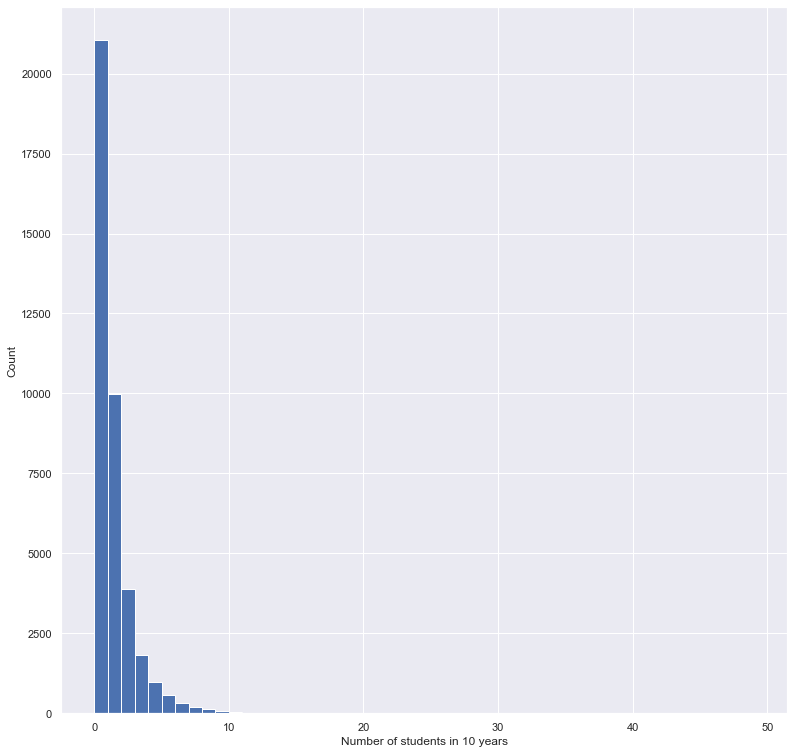

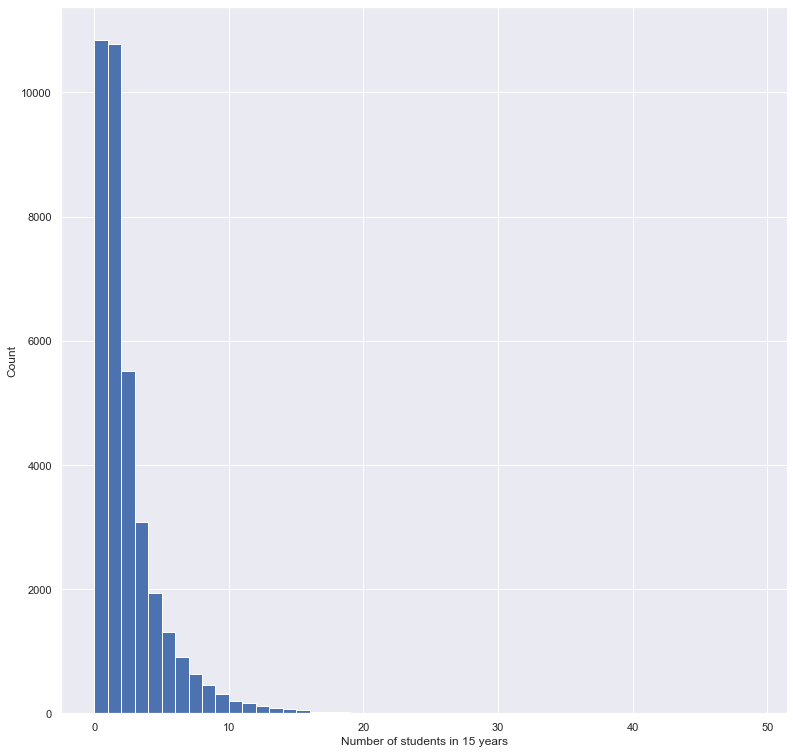

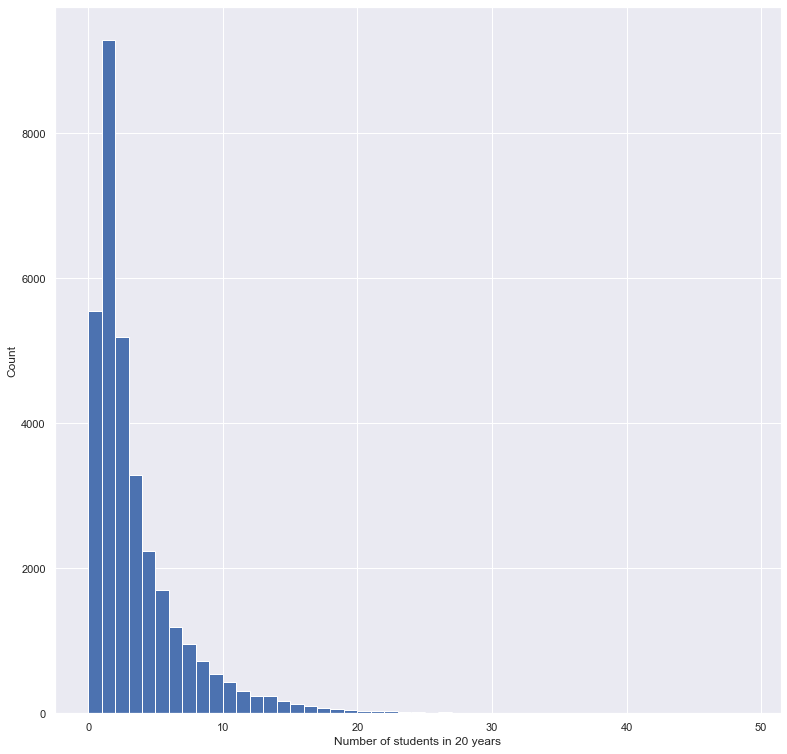

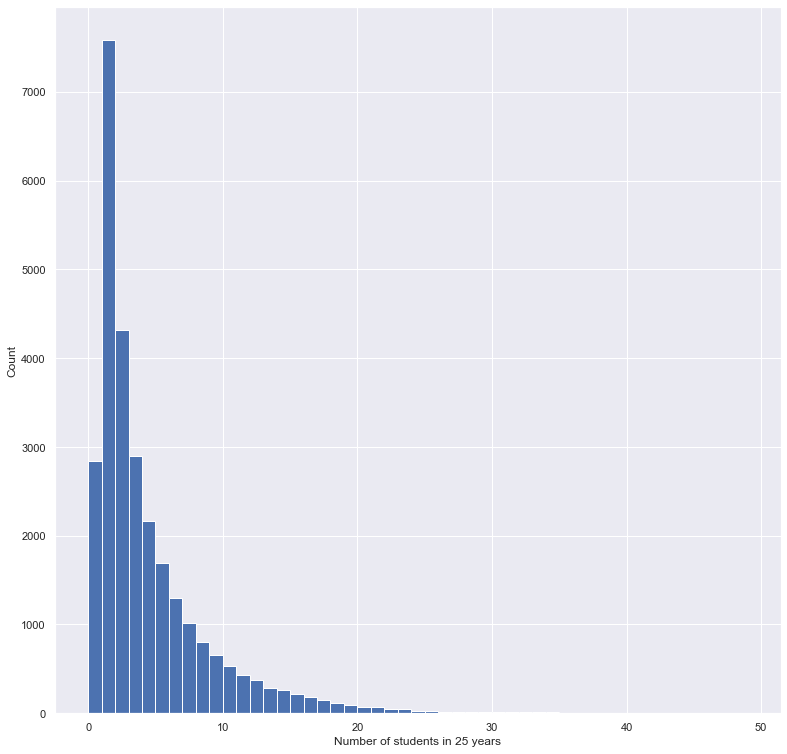

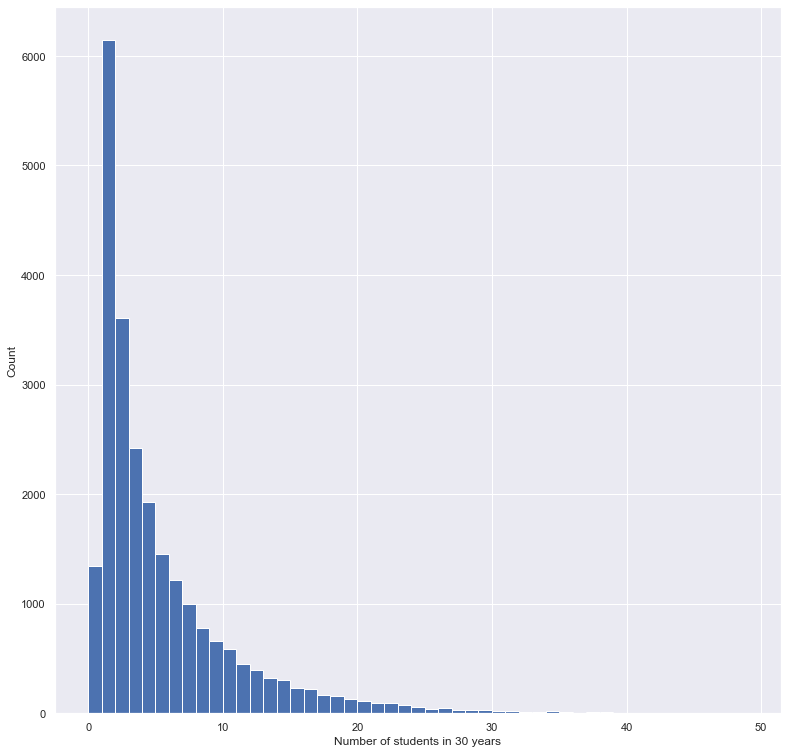

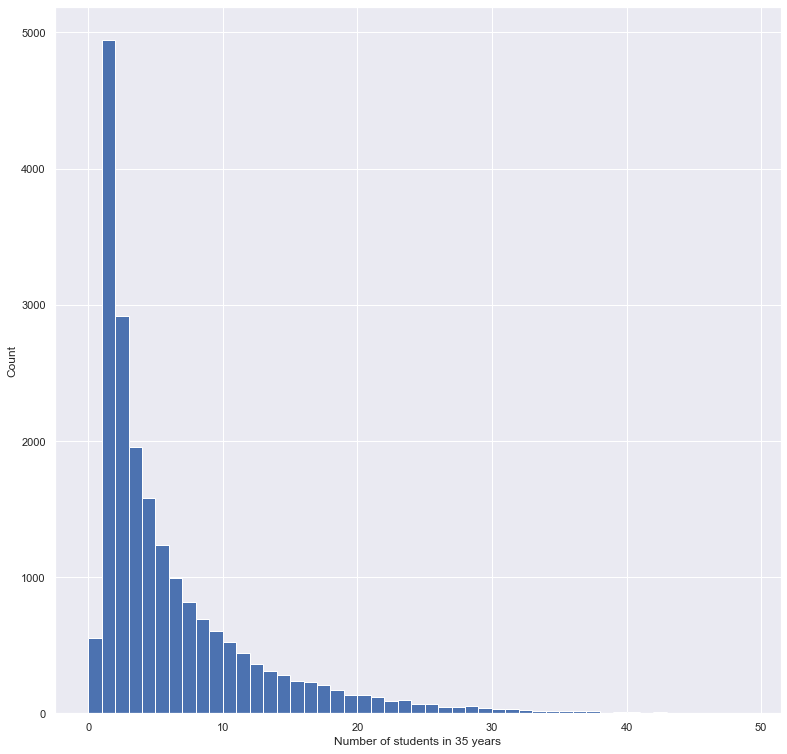

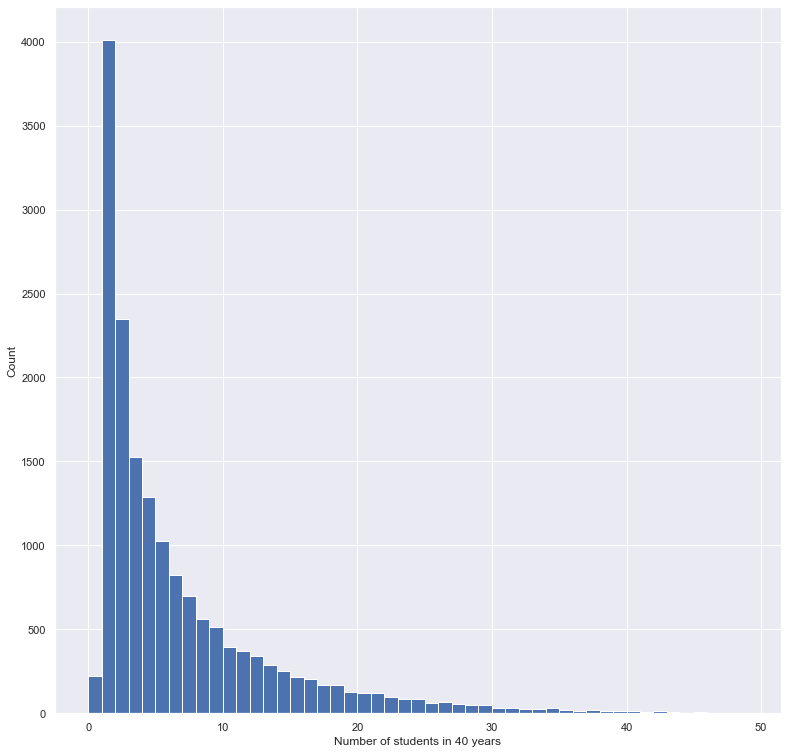

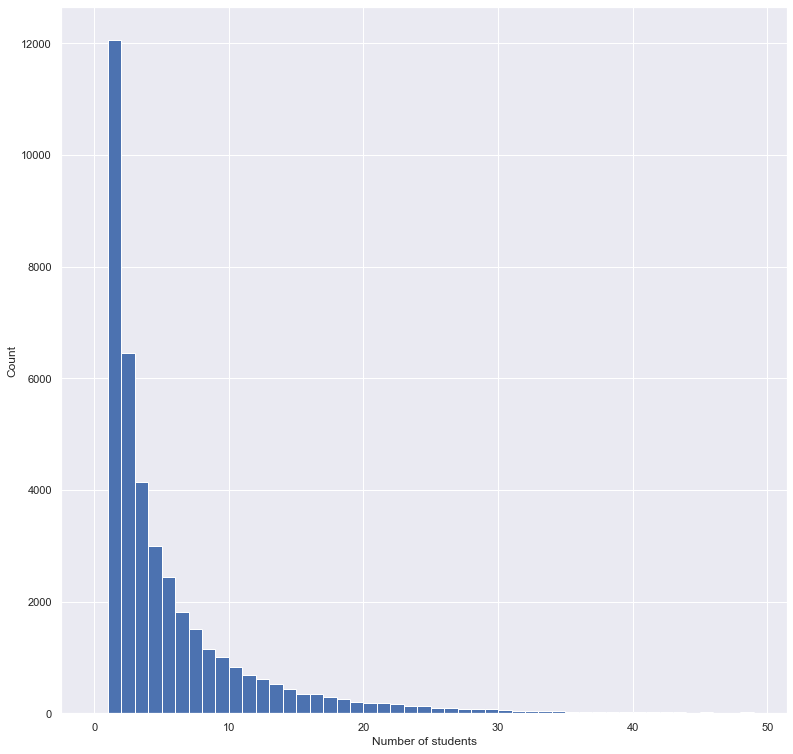

In [4]:
bins = [i for i in range(50)]

for i in range(8):
    _ = plt.hist(ad[(ad['num_students']<50) & (ad['career_length']>= (i+1)*5)]['num_students_in_%s_years'%((i+1)*5)]\
    , bins = bins)
    _ = plt.xlabel('Number of students in %s years'%((i+1)*5))
    _ = plt.ylabel('Count')
    plt.show()
    
fig, ax = plt.subplots()    
_ = plt.hist(ad[ad['num_students']<50]['num_students'],  bins = bins)
_ = plt.xlabel('Number of students')
_ = plt.ylabel('Count')
plt.show()


## 6. Histograms for number of students acquired over various 5-year intervals<a id='6._Histograms_for_number_of_students_acquired_over_various_5-year_intervals'></a>

In [ ]:
# acquired students

for i in range(1,8):
    ad['num_students_acquired_from_%s_to_%s_years'%(i*5,(i+1)*5)] = ad['num_students_in_%s_years'%((i+1)*5)] - ad['num_students_in_%s_years'%((i)*5)]
    

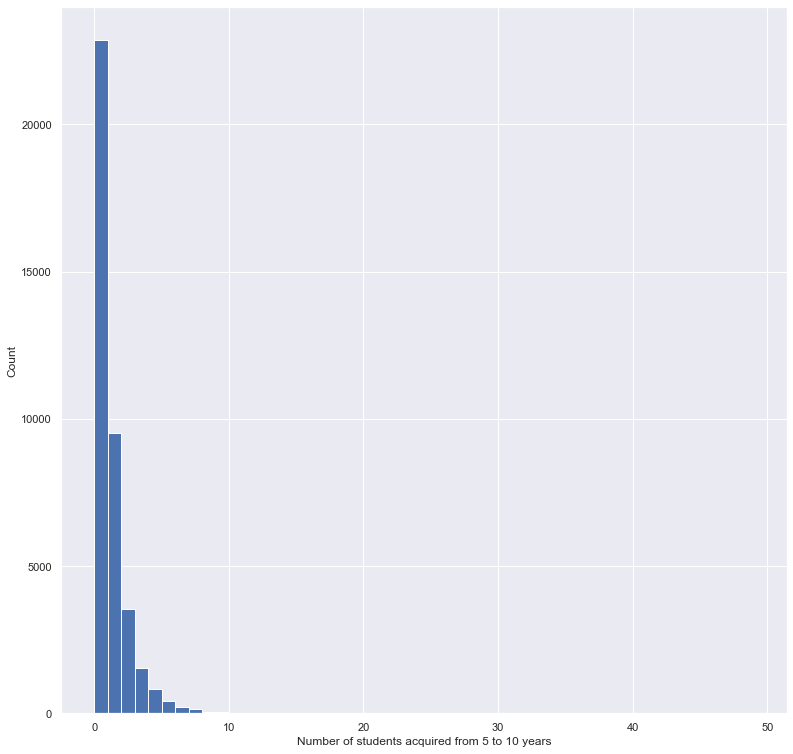

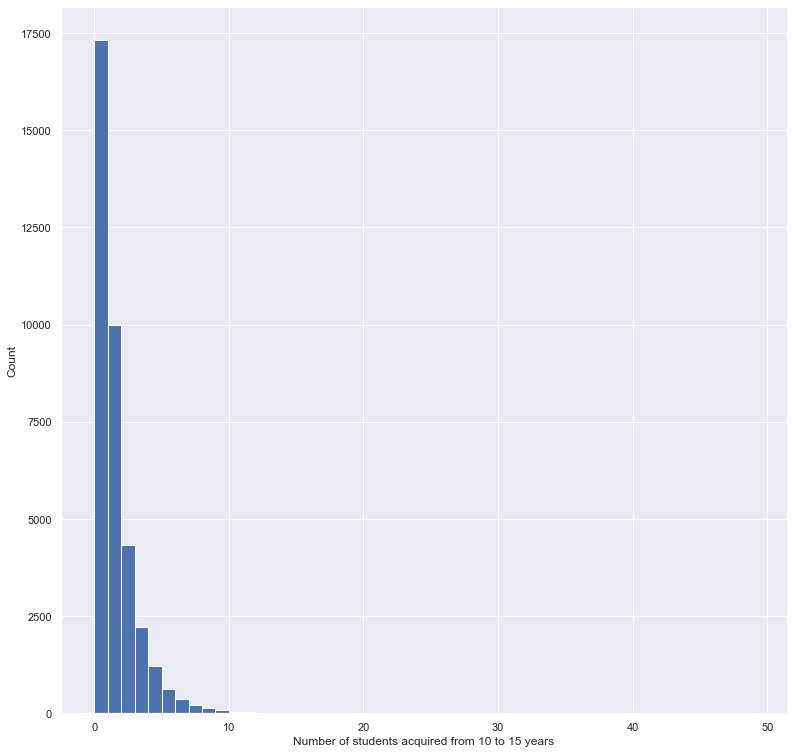

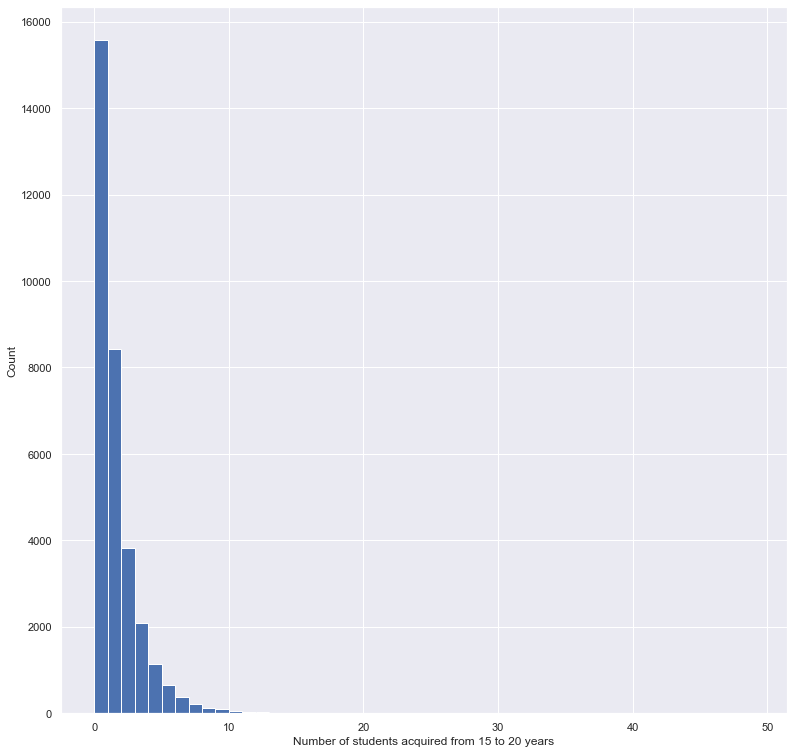

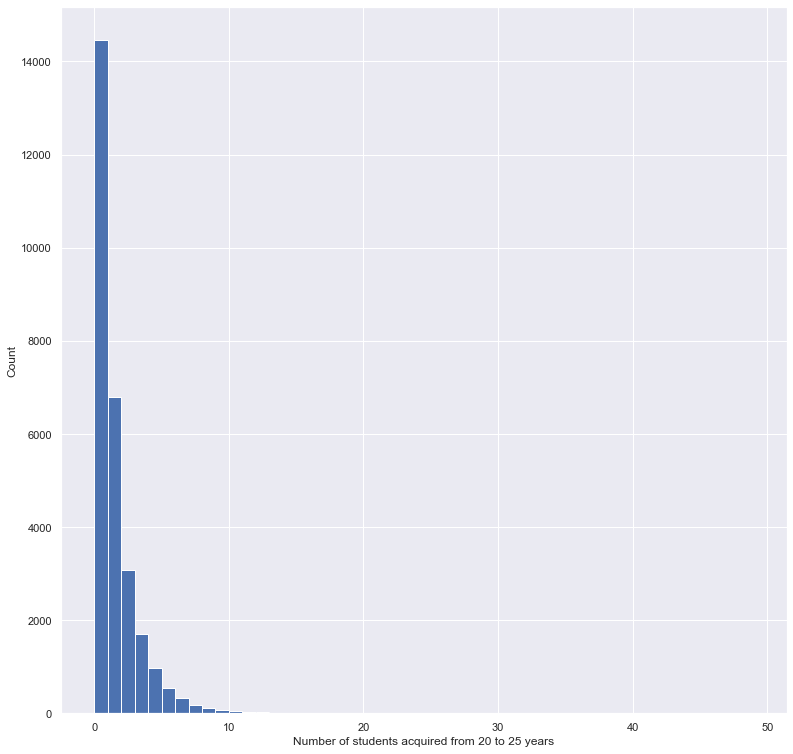

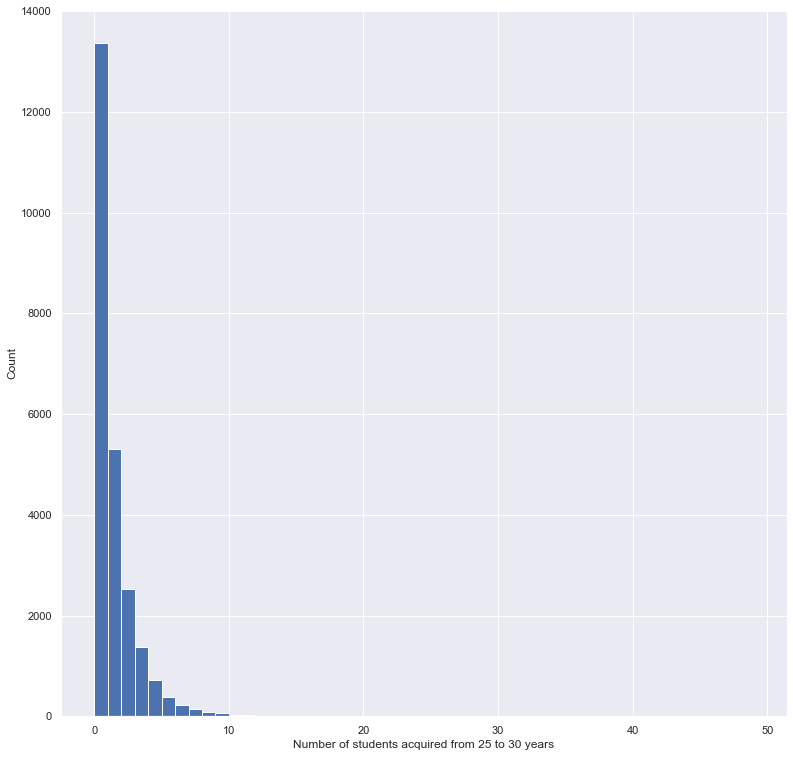

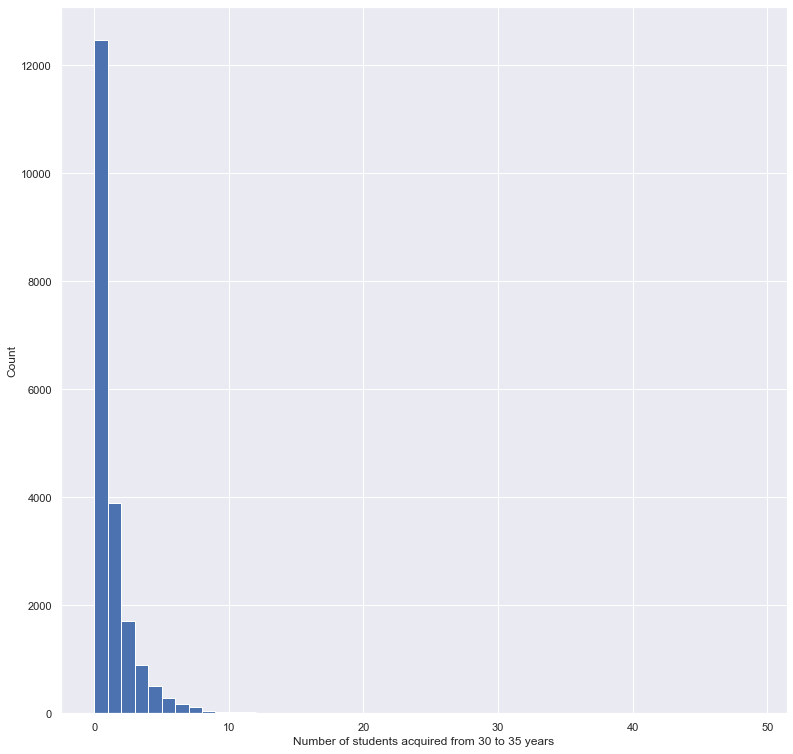

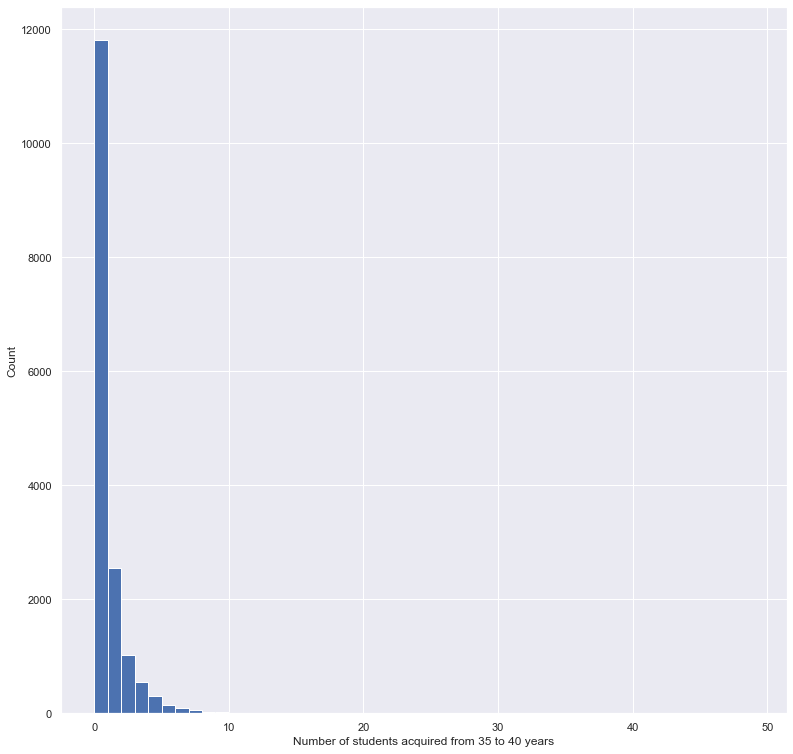

In [5]:
bins = [i for i in range(50)]

for i in range(1,8):
    _ = plt.hist(ad[(ad['num_students']<50) & (ad['career_length']>= (i+1)*5)]['num_students_acquired_from_%s_to_%s_years'%(i*5,(i+1)*5)]\
    , bins = bins)
    _ = plt.xlabel('Number of students acquired from %s to %s years'%(i*5,(i+1)*5))
    _ = plt.ylabel('Count')
    plt.show()

## 7. Boxplots for number of students acquired over various 5-year intervals<a id='7._Boxplots_for_number_of_students_acquired_over_various_5-year_intervals'></a>

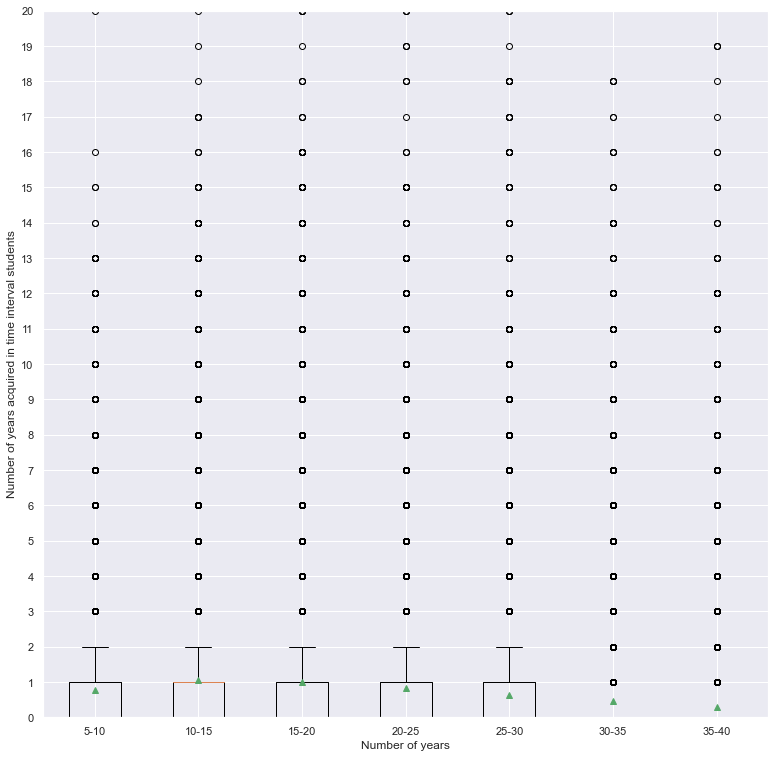

In [6]:
plt.boxplot([ad['num_students_acquired_from_%s_to_%s_years'%(i*5,(i+1)*5)] for i in range(1,8)], showmeans=True)
plt.xlabel('Number of years')
plt.ylabel('Number of years acquired in time interval students')
plt.xticks([1,2,3,4,5,6,7], ['5-10','10-15','15-20','20-25','25-30','30-35','35-40'])
plt.yticks([i for i in range(21)])
plt.ylim(0,20)
plt.show()

In [7]:
ad.describe()

,MGP_ID,MGP_ID.1,MScNetID,Year,MSC,num_students,num_descendants,num_advisors,Advisor_1_MGP_ID,Advisor_2_MGP_ID,Advisor_3_MGP_ID,Advisor_4_MGP_ID,Advisor_5_MGP_ID,Advisor_6_Name,Advisor_6_MGP_ID,Earliest_Pub,Total_Pubs,Total_Rel_Pubs,Total_Citations,Num_Collaborators,Num_Subjects,career_length,num_students_in_5_years,num_students_in_10_years,num_students_in_15_years,num_students_in_20_years,num_students_in_25_years,num_students_in_30_years,num_students_in_35_years,num_students_in_40_years,num_students_acquired_from_5_to_10_years,num_students_acquired_from_10_to_15_years,num_students_acquired_from_15_to_20_years,num_students_acquired_from_20_to_25_years,num_students_acquired_from_25_to_30_years,num_students_acquired_from_30_to_35_years,num_students_acquired_from_35_to_40_years,Advisor_students,school_producers,pubs_per_year,citations_per_year
count,39956.000000,39956.000000,3.995600e+04,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,0.0,39956.0,39956.000000,39956.000000,39956.0,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000,39956.000000
mean,88703.881770,88703.881770,3.839416e+05,1981.911703,29.752202,5.452723,109.510286,1.108444,58872.340875,11433.132771,663.087972,46.447692,6.341976,NaN,0.0,1972.192111,43.690434,0.0,400.788818,21.873411,5.659450,31.425168,0.184103,0.959856,2.015892,3.014591,3.844003,4.488262,4.942612,5.224247,0.775753,1.056037,0.998699,0.829412,0.644259,0.454350,0.281635,15.288986,0.265603,1.459107,12.637417
std,64147.084963,64147.084963,2.763259e+05,22.533094,35.065261,7.246397,3104.030699,0.460507,56653.907039,35576.781585,9930.819913,2744.128134,922.941247,NaN,0.0,145.950592,52.658381,0.0,909.967804,25.149837,4.067006,10.445095,0.602704,1.603366,2.678646,3.768280,4.761746,5.597239,6.273070,6.769359,1.305464,1.614224,1.716526,1.624685,1.460732,1.253899,1.032978,15.232954,0.117712,1.638327,25.203298
min,4.000000,4.000000,2.200500e+04,1406.000000,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34373.250000,34373.250000,1.686462e+05,1970.000000,-1.000000,1.000000,1.000000,1.000000,15884.250000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,1970.000000,12.000000,0.0,19.000000,6.000000,3.000000,23.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.187678,0.414634,0.645161
50%,77510.500000,77510.500000,2.851980e+05,1985.000000,5.000000,3.000000,4.000000,1.000000,41315.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,1985.000000,29.000000,0.0,114.000000,15.000000,5.000000,35.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,3.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.254005,1.048780,4.115282
75%,131227.750000,131227.750000,6.421035e+05,1997.000000,62.000000,7.000000,12.000000,1.000000,84508.250000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,1998.000000,57.000000,0.0,400.000000,29.000000,8.000000,40.000000,0.000000,1.000000,3.000000,4.000000,5.000000,6.000000,6.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,21.000000,0.316966,2.000000,14.125000
max,264075.000000,264075.000000,1.323669e+06,2017.000000,97.000000,153.000000,169019.000000,5.000000,264137.000000,264138.000000,244937.000000,230605.000000,157767.000000,NaN,0.0,2020.000000,1445.000000,0.0,28833.000000,655.000000,44.000000,68.000000,22.000000,45.000000,49.000000,85.000000,115.000000,

## 8. CDFs and PDFs for number of students over various time intervals<a id='8._CDFs_and_PDFs_for_number_of_students_over_various_time_intervals'></a>

In [8]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1)/len(x)
    return x, y

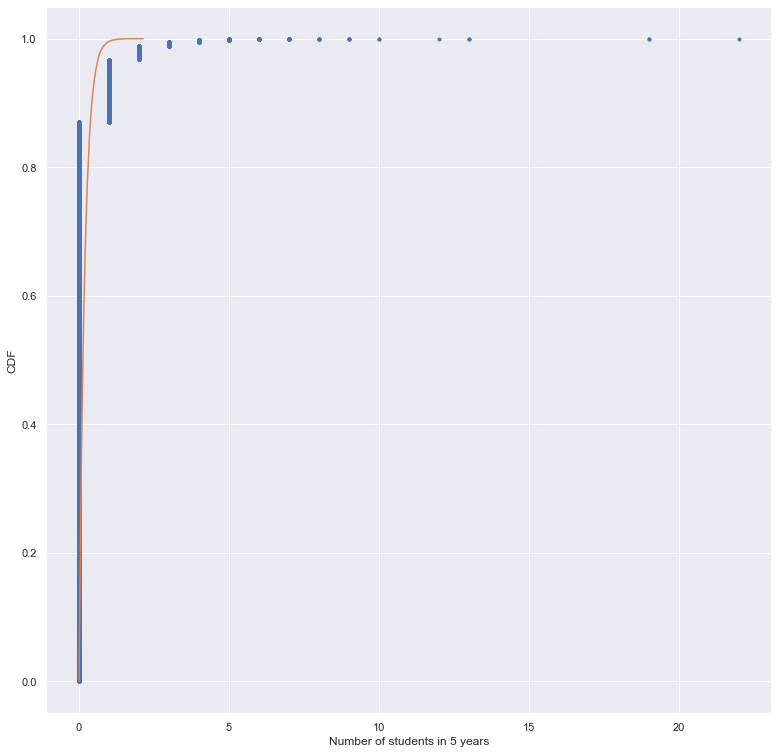

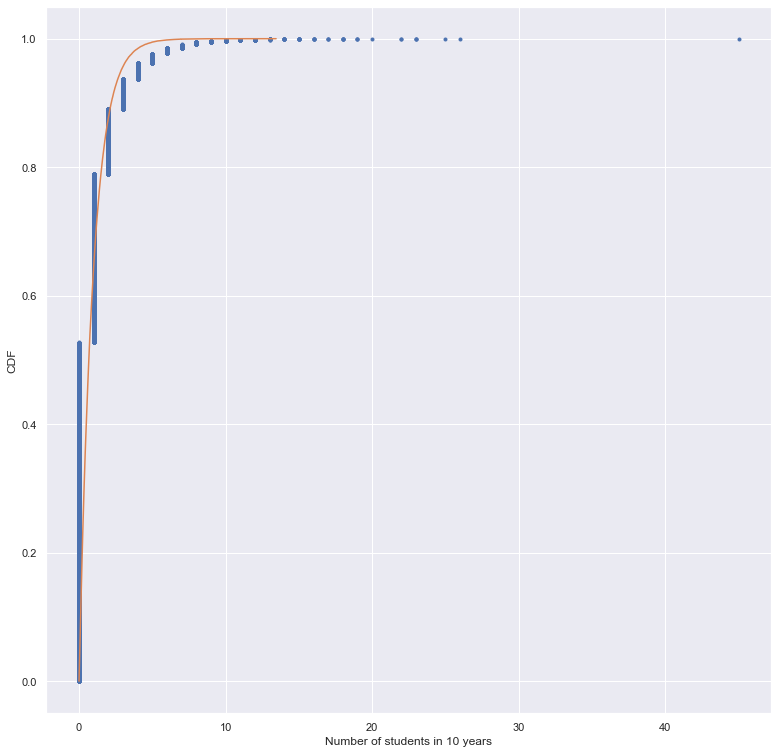

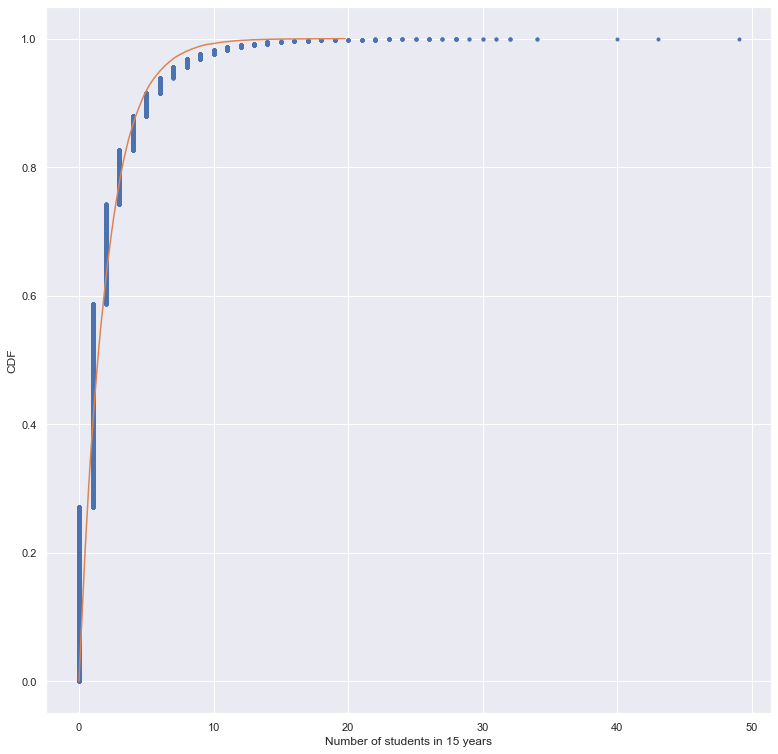

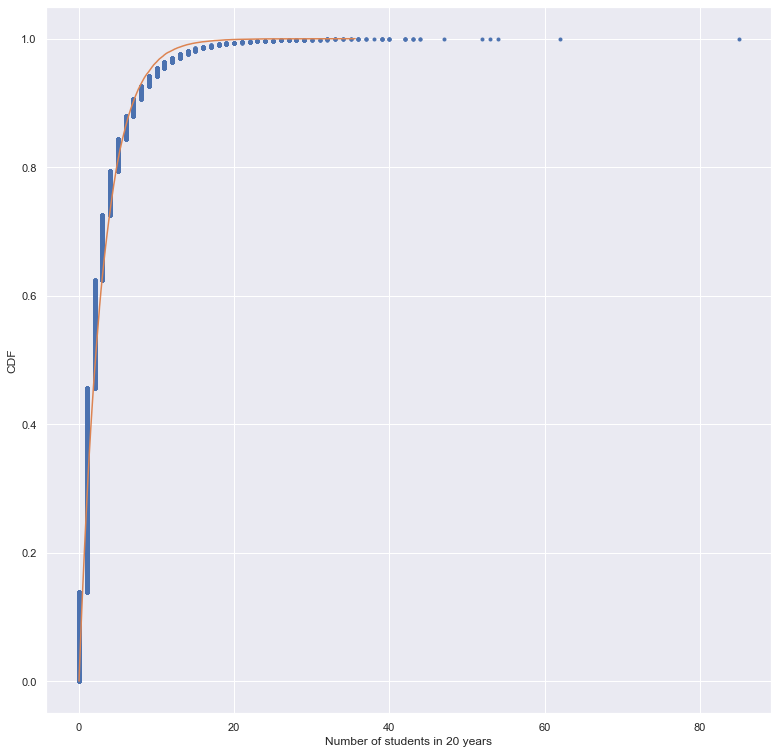

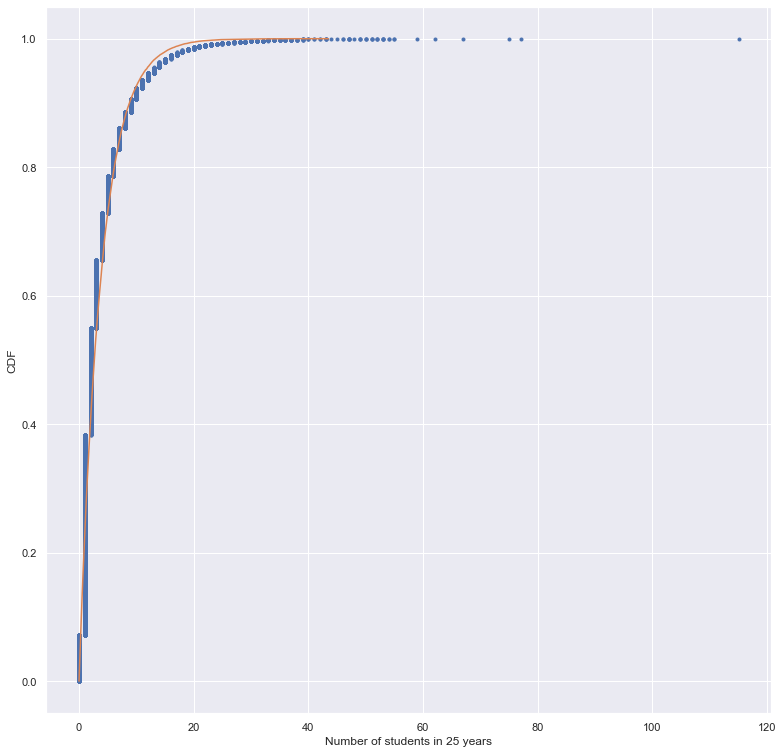

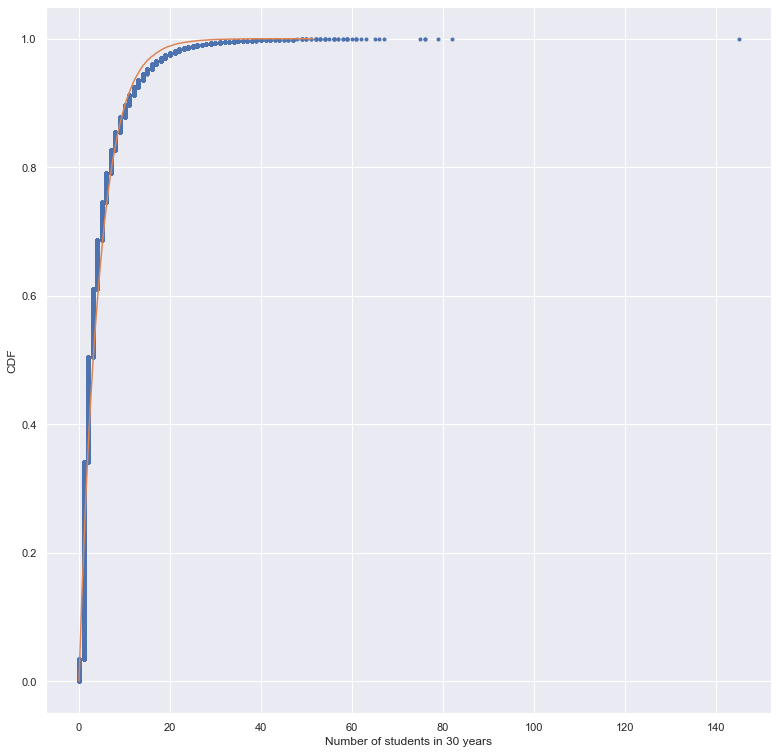

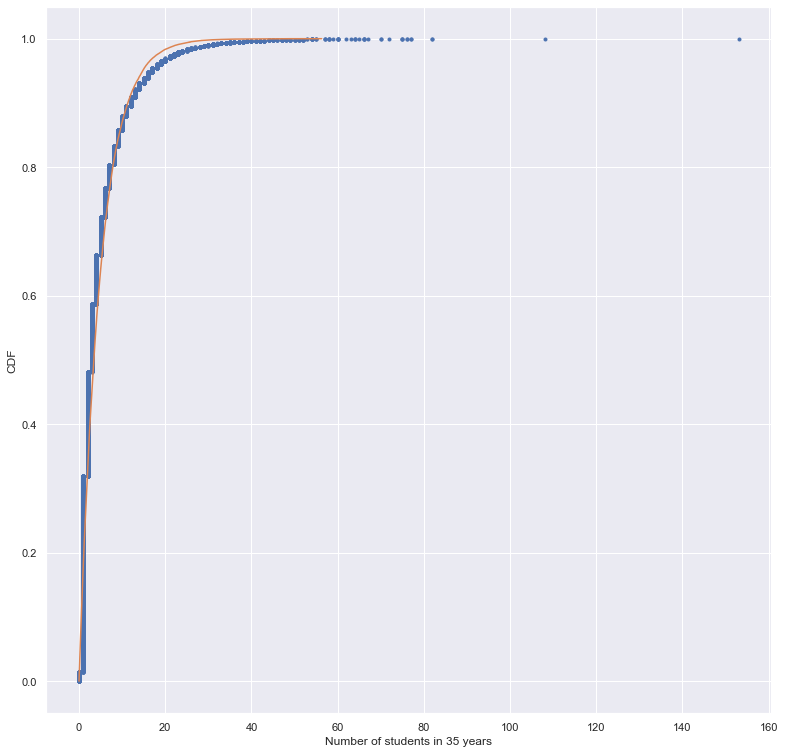

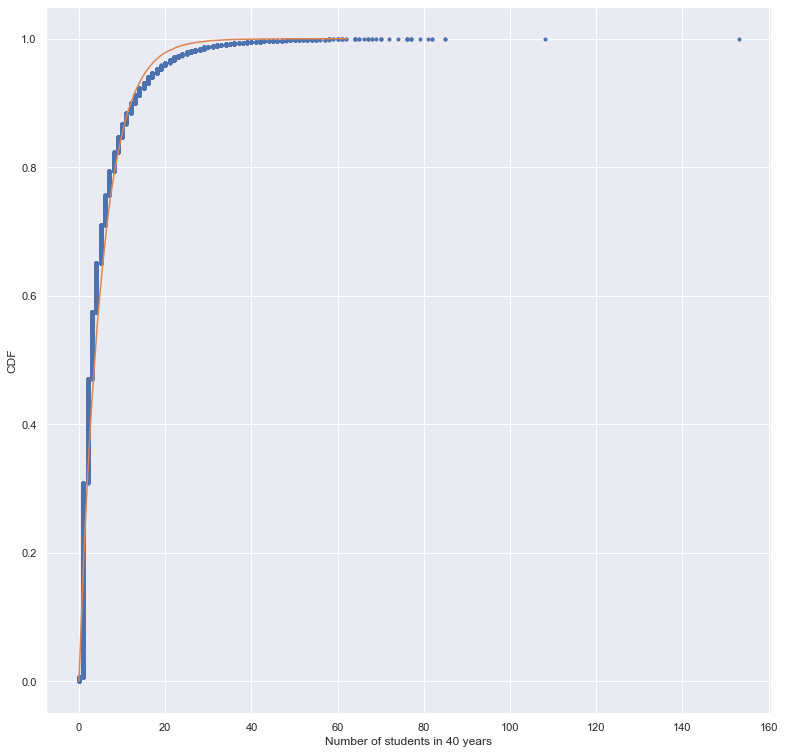

In [9]:
for i in range(8):
    mean = np.mean(ad['num_students_in_%s_years'%((i+1)*5)])
    samples = np.random.exponential(mean, size = 50000)
    x, y = ecdf(ad['num_students_in_%s_years'%((i+1)*5)])
    x_theor, y_theor = ecdf(samples)
    _ = plt.plot(x,y, marker='.', linestyle='none')
    _ = plt.plot(x_theor,y_theor)
    _ = plt.xlabel('Number of students in %s years'%((i+1)*5))
    _ = plt.ylabel('CDF')
    plt.show()


Close fit to exponential distribution in terms of CDF. Now check PDF vid violin plots.

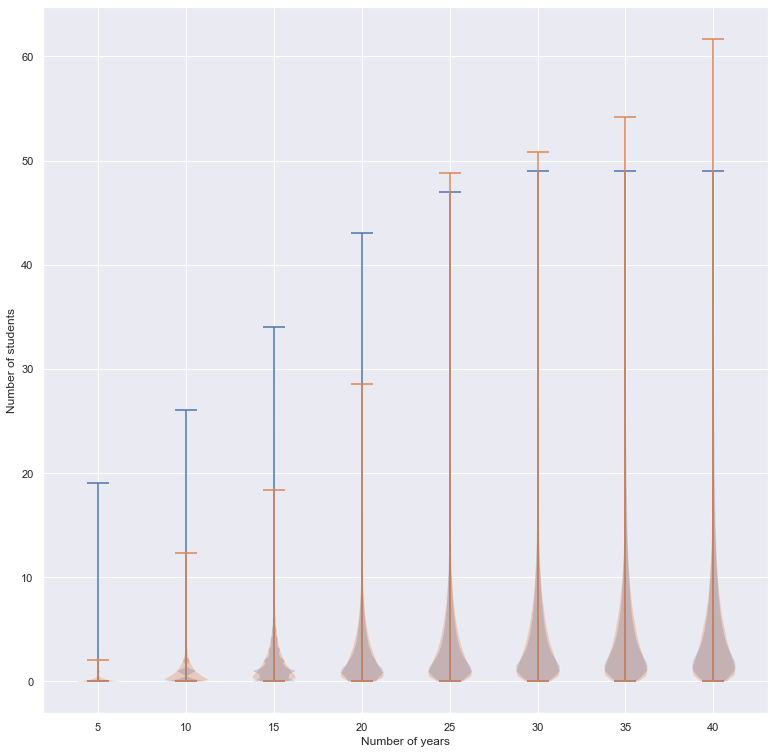

In [10]:

_ = plt.violinplot([ad[(ad['num_students']<50) & (ad['career_length']>= (i+1)*5)]\
                   ['num_students_in_%s_years'%((i+1)*5)] for i in range(8)])
_ = plt.violinplot([np.random.exponential(np.mean(ad['num_students_in_%s_years'%((i+1)*5)]),\
                                          size = 50000) for i in range(8)])
_ = plt.xticks([(i+1) for i in range(8)],[str((i+1)*5) for i in range(8)])
_ = plt.xlabel('Number of years')
_ = plt.ylabel('Number of students')

plt.show()


We will focus on number of students obtained in 20 years

## 9. Obtaining more features<a id='9._Obtaining_more_features'></a>

In [ ]:
def adv_stu(rec):
    num = 0
    count = 0
    for i in range(6):
        adv_id = df.loc[rec,'Advisor_%s_MGP_ID'%(i+1)] 
        if adv_id !=0:
            num += df.loc[adv_id, 'num_students']
            count += 1
    if count != 0:
        return num/count
    else:
        return 0

In [ ]:
ad['Advisor_students'] = ad['MGP_ID'].apply(adv_stu)


In [ ]:
school_totals = df.School.value_counts()

In [ ]:
school_producers = df[df['num_students']>0].School.value_counts()

In [ ]:
def sch_prod(school):
    try:
        return school_producers[school] / school_totals[school]
    except:
        return 0

In [ ]:
ad['school_producers'] = ad['School'].apply(sch_prod)

In [ ]:
ad['pubs_per_year'] = ad['Total_Pubs'].divide(ad['career_length'])

In [ ]:
ad['citations_per_year'] = ad['Total_Citations'].divide(ad['career_length'])

## 10. Obtaining dataframe for advisors with career length at least 20 years<a id='10._Obtaining_dataframe_for_advisors_with_career_length_at_least_20_years'></a>

In [ ]:
# data frame with career length >= 20

ad20 = ad[ad['career_length']>=20]
ad20.shape

Save dataframes so we don't have to go through all the computations again.

In [ ]:
ad.to_excel('advisor_table.xlsx')
ad20.to_excel('advisor20_table.xlsx')

## 11. Visualizations of correlations<a id='11._Visualizations_of_correlations'></a>

### 11.1 Heatmap<a id='11.1_Heatmap'></a>

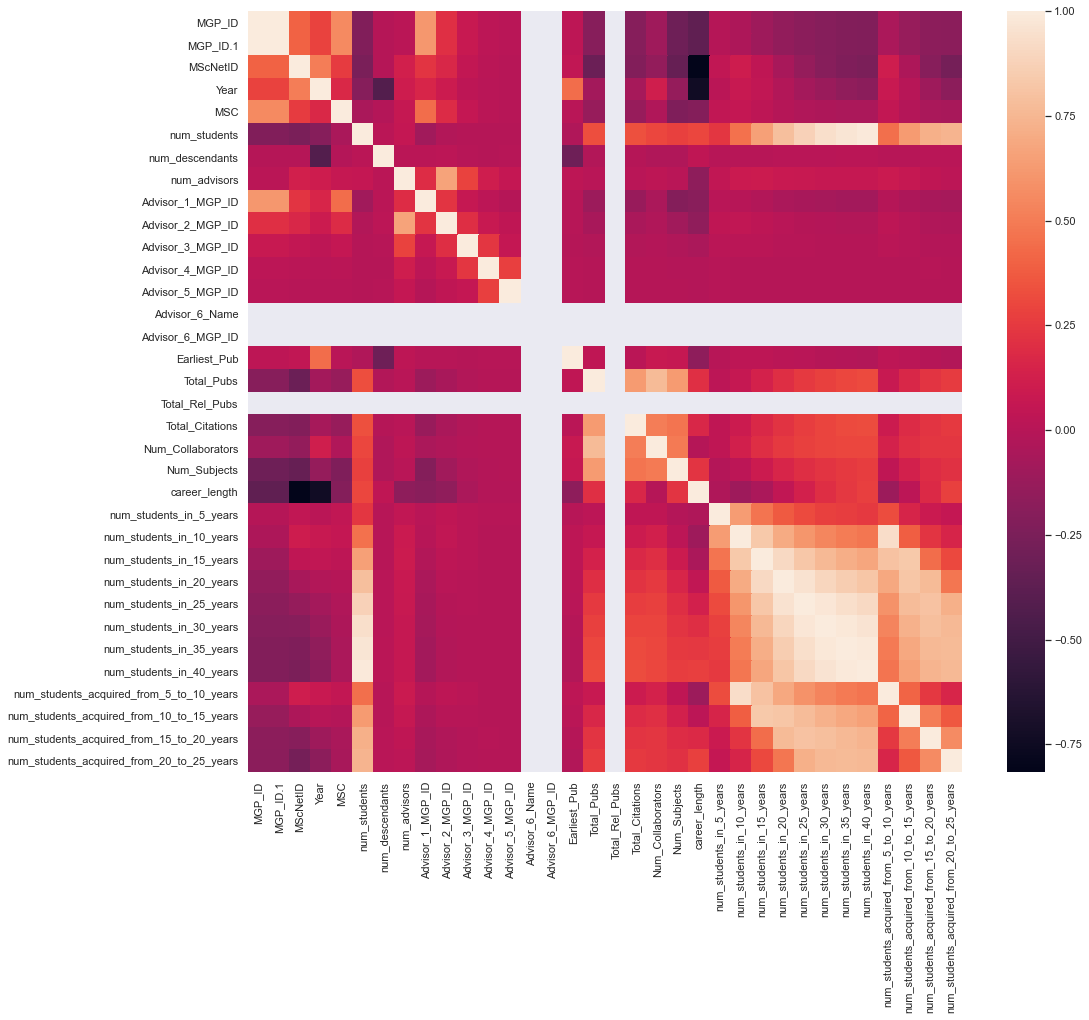

In [11]:
plt.subplots(figsize=(16,14))
sns.heatmap(ad.iloc[:,:-7].corr(), annot=False)
plt.show()

### 11.2 Pairplot<a id='11.2_Pairplot'></a>

In [12]:
# list of columns to compare with number of students in 20 years

xes = ['pubs_per_year','citations_per_year','Advisor_students','school_producers', 'Num_Collaborators', 'Num_Subjects']

xes_ns = xes+['num_students']

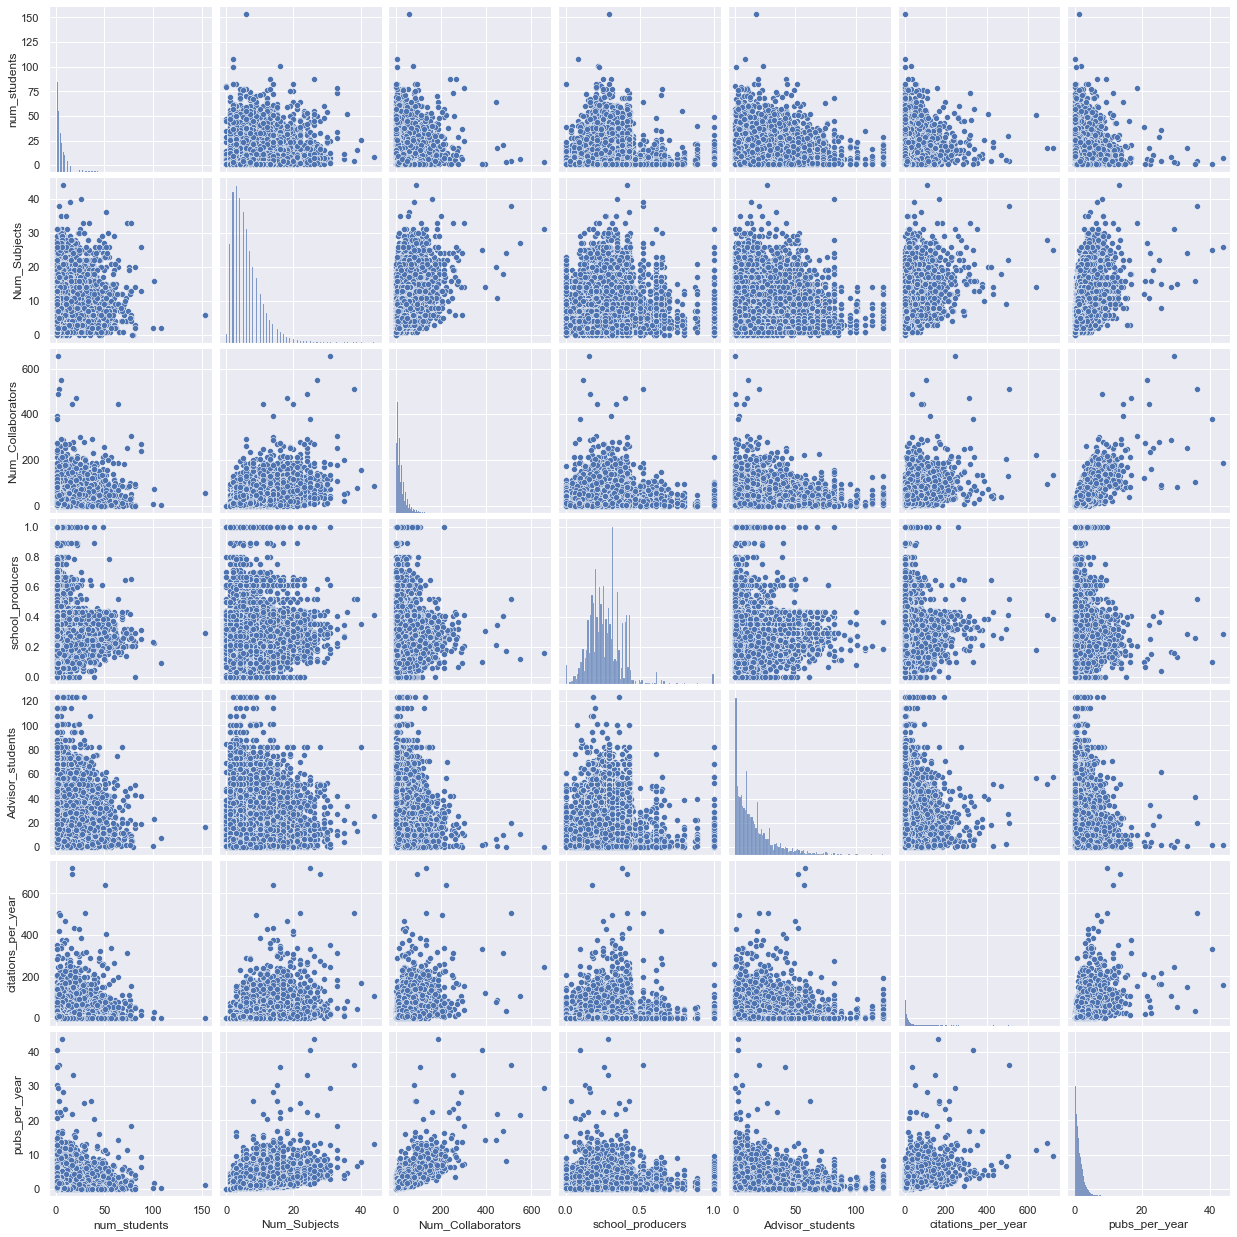

In [13]:
sns.pairplot(ad20[xes_ns[::-1]])
plt.show()

### 11.3 Scatter plots with 4 regression curves<a id='11.3_Scatter_plots_with_4_regression_curves'></a>

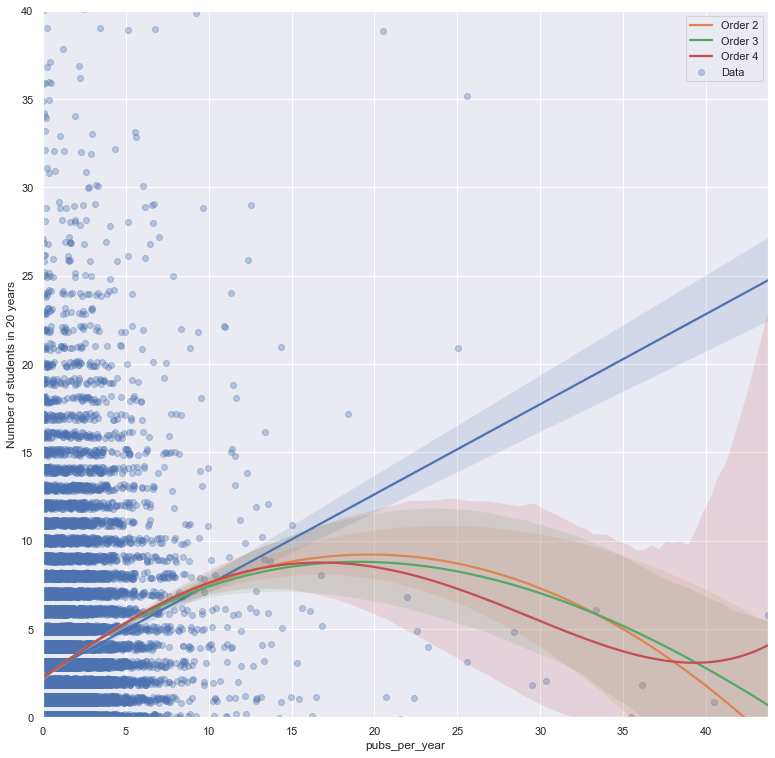

Correlation:  [[1.         0.20265443]
 [0.20265443 1.        ]]


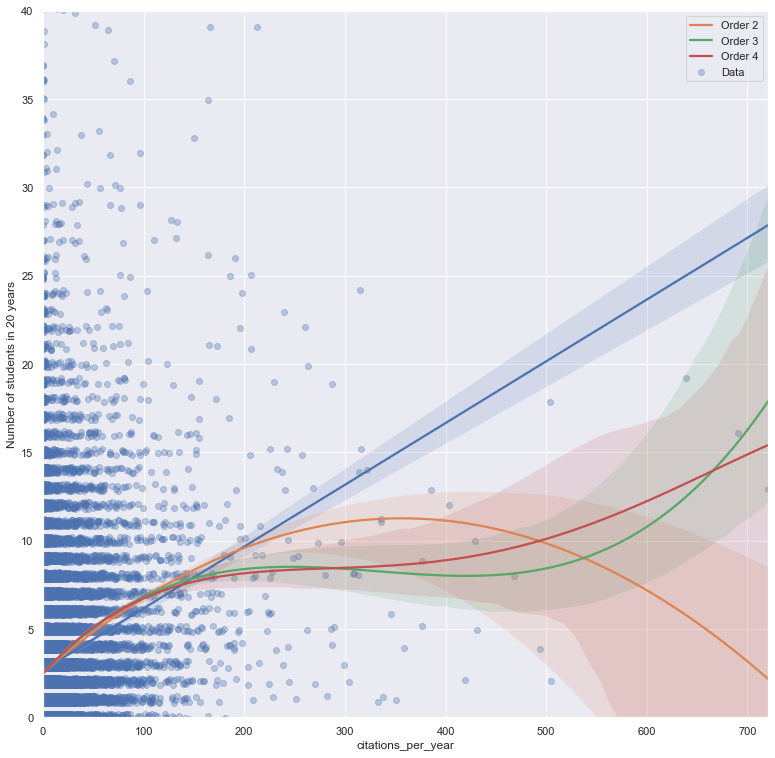

Correlation:  [[1.         0.23052504]
 [0.23052504 1.        ]]


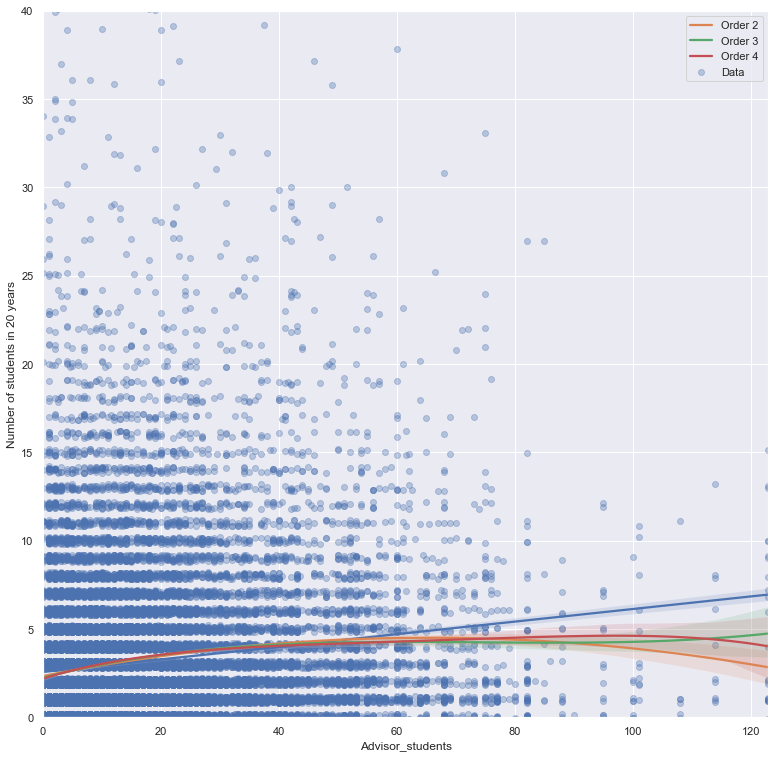

Correlation:  [[1.         0.13991612]
 [0.13991612 1.        ]]


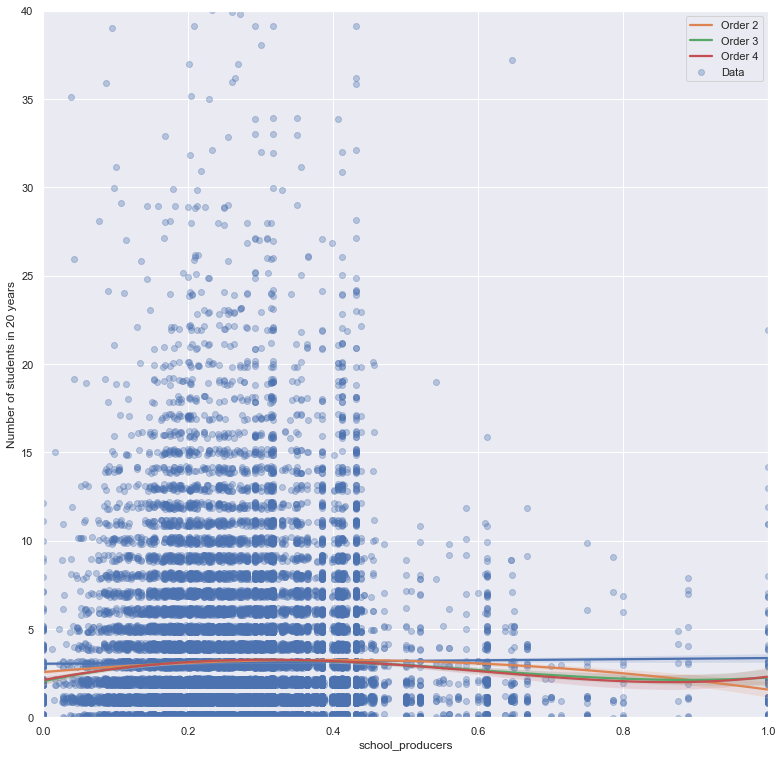

Correlation:  [[1.         0.00942299]
 [0.00942299 1.        ]]


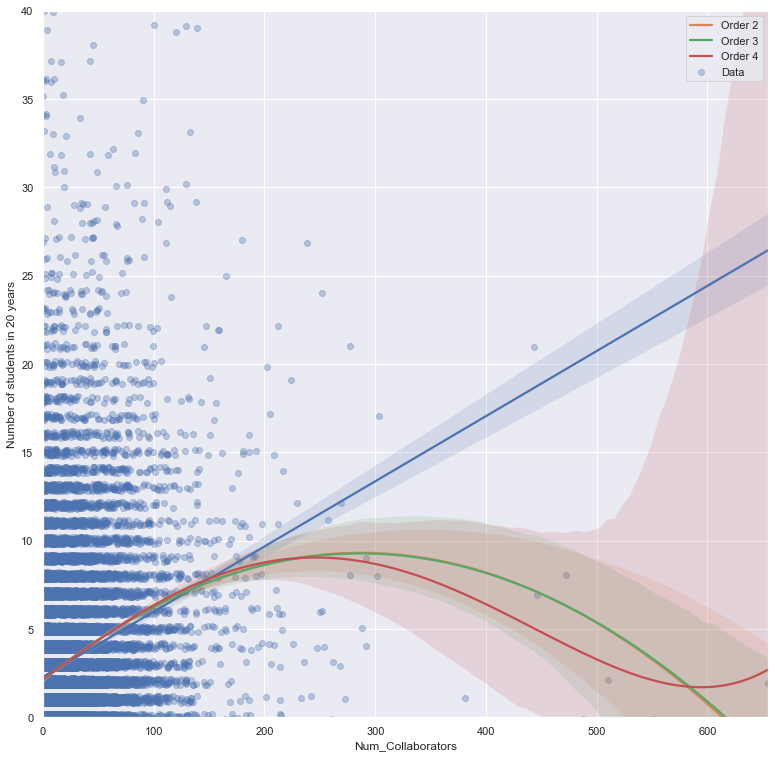

Correlation:  [[1.         0.24408454]
 [0.24408454 1.        ]]


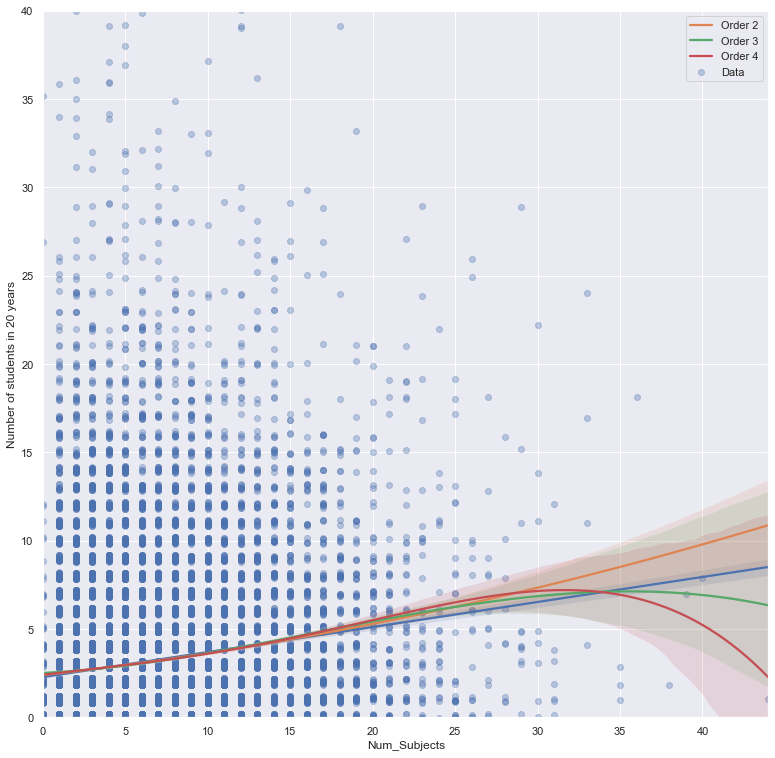

Correlation:  [[1.         0.15112136]
 [0.15112136 1.        ]]


In [14]:
for x in xes:
    sns.regplot(x=x, y='num_students_in_20_years', data=ad20, label='Data', y_jitter = 0.2, scatter_kws = {'alpha' : 1/3})
    for i in range(2,5):
        sns.regplot(x=x, y='num_students_in_20_years', data=ad20, order=i, scatter=None, label='Order %s'%(i))
    plt.ylim(0,40)
    plt.xlabel(x)
    plt.ylabel('Number of students in 20 years')
    plt.legend(loc='upper right')
    plt.show()
    print('Correlation: ', np.corrcoef(ad20[x], ad20['num_students_in_20_years']))

### 11.4 Aside: `Num_Collaborators` and `Total_Pubs` exhibit strong correlation<a id='11.4_Aside'></a>

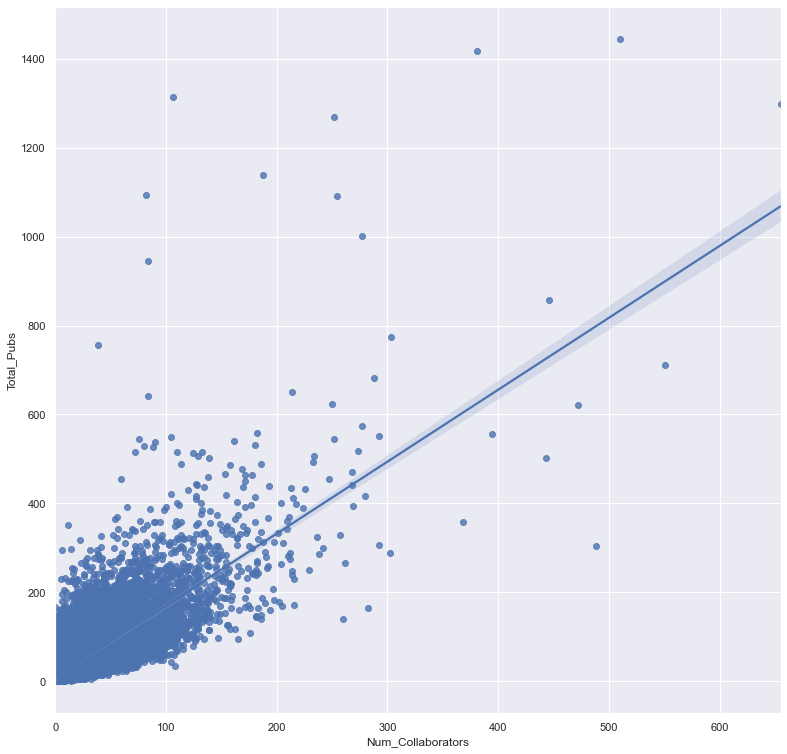

[[1.         0.77281624]
 [0.77281624 1.        ]]


In [15]:
sns.regplot(x='Num_Collaborators', y='Total_Pubs', data=ad)
plt.show()
print(np.corrcoef(ad.Num_Collaborators, ad.Total_Pubs))